In [1]:
# for database and dataframe
import sqlite3
import pandas as pd

# for plotting and processing
from tqdm import tqdm
import matplotlib.pyplot as plt

# utils for I/O with database
import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if  torch.backends.mps.is_available() else 'cpu')
print(device)

mps


# Load distributions from file

In [8]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1001 # random seed 
}
file_distributions = f"./dat/empirical_pmf_N={params['N']}_K={params['K']}_mu={params['mu']}_seed={params['seed']}.h5"

In [21]:
# load data
Xs = []
Ys = []
# datasets: window={window}/1-lambda={1-lambda_}/h={h}/pmf
with h5py.File(file_distributions, 'r') as file:
    for group_window in tqdm(file.keys()):
        for group_lambda in file[group_window].keys():
            for group_h in file[group_window][group_lambda].keys():
                window = float(group_window.split('=')[1])
                lambda_ = 1 - float(group_lambda.split('=')[1])
                h = float(group_h.split('=')[1])
                pmf = file[group_window][group_lambda][group_h]['pmf']
                Xs.append(np.array([window, lambda_, h]))
                Ys.append(np.array(pmf))
print(f"Loaded {len(Xs)} distributions from {file_distributions}")
Xs = np.array(Xs)  
Ys = np.array(Ys)
print(Xs[-1], Ys[-1])

100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Loaded 3162 distributions from ./dat/empirical_pmf_N=10000_K=100_mu=0.2_seed=1001.h5
[1.00000000e-06 9.99900000e-01 5.62341325e-07] [0.97944317 0.00248932 0.00184589 ... 0.         0.         0.        ]


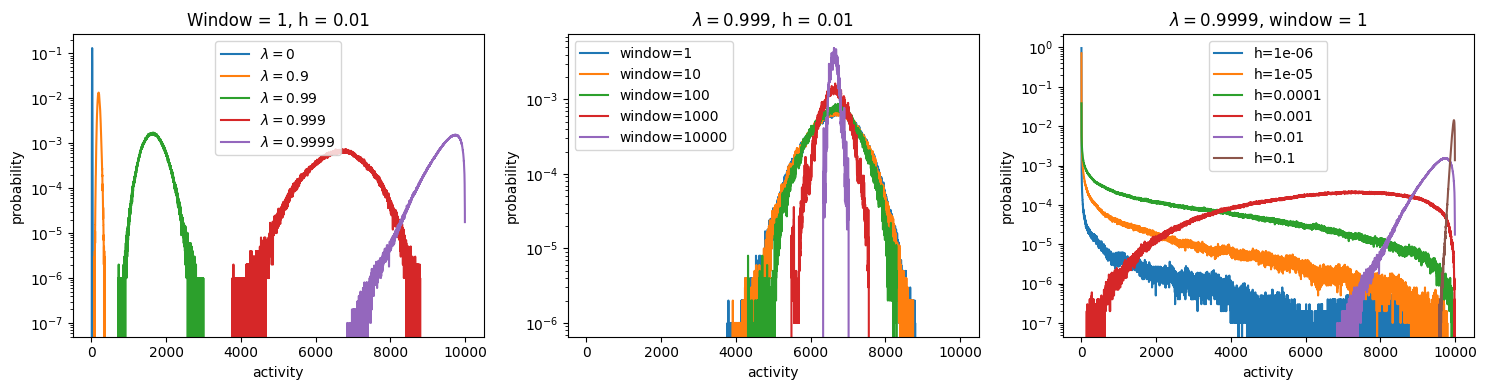

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# distributions for window 1, h=0.01 and lambdas [0 0.9 0.99, 0.999, 0.9999]
for i, lambda_ in enumerate([0, 0.9, 0.99, 0.999, 0.9999]):
    id = np.argwhere((Xs[:, 0]==1) & (Xs[:, 1]==lambda_) & (Xs[:,2]==0.01))[0][0]
    axes[0].plot(Ys[id], label=f"$\lambda={lambda_}$")
axes[0].set_title(f"Window = 1, h = 0.01")
axes[0].legend()
axes[0].set_xlabel("activity")
axes[0].set_ylabel("probability")
axes[0].set_yscale('log')
# distributions for window [1,10,100,1000,10000], h=0.01 and lambdas [0.999]
for i, window in enumerate([1,10,100,1000,10000]):
    id = np.argwhere((Xs[:, 0]==window) & (Xs[:, 1]==0.999) & (Xs[:,2]==0.01))[0][0]
    axes[1].plot(Ys[id], label=f"window={window}")
axes[1].set_title(f"$\lambda=0.999$, h = 0.01")
axes[1].legend(loc='upper left')
axes[1].set_xlabel("activity")
axes[1].set_ylabel("probability")
axes[1].set_yscale('log')
# distributions for window 1, h=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1] and lambdas [0.9999]
for i, h in enumerate([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]):
    id = np.argwhere((Xs[:, 0]==1) & (Xs[:, 1]==0.9999) & (Xs[:,2]==h))[0][0]
    axes[2].plot(Ys[id], label=f"h={h}")
axes[2].set_title(f"$\lambda=0.9999$, window = 1")  
axes[2].legend(loc='upper center')
axes[2].set_xlabel("activity")
axes[2].set_ylabel("probability")
axes[2].set_yscale('log')
plt.tight_layout()

In [48]:
# transform data:
# [window, lambda, h] -> [log10(window), log10(1-lambda), log10(h)]
_Xs = Xs.copy()
_Xs[:, 0] = np.log10(Xs[:, 0])
_Xs[:, 1] = np.log10(1 - Xs[:, 1])
_Xs[:, 2] = np.log10(Xs[:, 2])
# [pmf] -> [log10(pmf)]
# need to add small constant to avoid log(0)
# _Ys = np.log10(Ys + 1e-10)
_Ys = Ys.copy()

In [52]:
print(f"construct neural network to map input of shape {_Xs.shape} to output of shape {_Ys.shape}")
TODO: this is the wrong network I suppose. We rather want an model where Y[:,i] is a function of Y[:,i-1]. This is a type of autoregressive network.
# hidden_sizes = [_Ys.shape[1]]
# while hidden_sizes[-1] > 10*_Xs.shape[1]:
#     hidden_sizes.append(hidden_sizes[-1] // 3)
# hidden_sizes = hidden_sizes[::-1]
hidden_sizes = [_Ys.shape[1], _Ys.shape[1], _Ys.shape[1]]
model = DenseNN(input_size=_Xs.shape[1], output_size=_Ys.shape[1], hidden_sizes=hidden_sizes, act=nn.ReLU())
print(model)

SyntaxError: unmatched ')' (138266351.py, line 2)

Training: 100%|██████████| 100/100 [09:22<00:00,  5.63s/it]


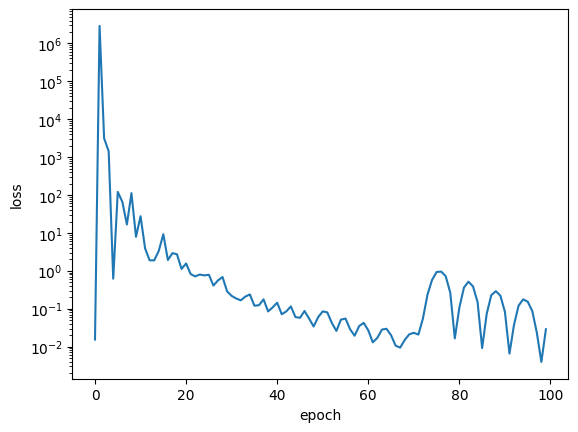

In [50]:
epochs = 100
alpha = 0.0
beta = 0.0
lr = 0.005

# convert to torch tensors
X_tensor = torch.from_numpy(_Xs).float().to(device)
Y_tensor = torch.from_numpy(_Ys).float().to(device)
model_tensor = model.to(device)

# Adam and MSE Loss
optimizer = optim.Adam(model_tensor.parameters(), lr=lr)
std_loss = nn.MSELoss(reduction="mean") 
def loss_fn(Y_pred, Y):
    loss = std_loss(Y_pred, Y)
    # force neighbouring Ys to be similar
    loss += alpha*torch.mean(torch.abs(Y_pred[:, 1:] - Y_pred[:, :-1]))
    # ensure normalization
    loss += beta*torch.mean(torch.abs(torch.sum(Y_pred, dim=1) - 1))
    return loss

history_loss = []
for epoch in tqdm(range(epochs), desc="Training"):
    Y_pred = model_tensor(X_tensor)
    loss = loss_fn(Y_pred, Y_tensor)
    history_loss.append(loss.item())
    # compute gradients
    loss.backward()
    # update parameters
    optimizer.step()
    # zero the parameter gradients
    optimizer.zero_grad()

model = model_tensor.to("cpu")
model.train(False)

#plot history_loss
plt.figure()
plt.plot(history_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.show()

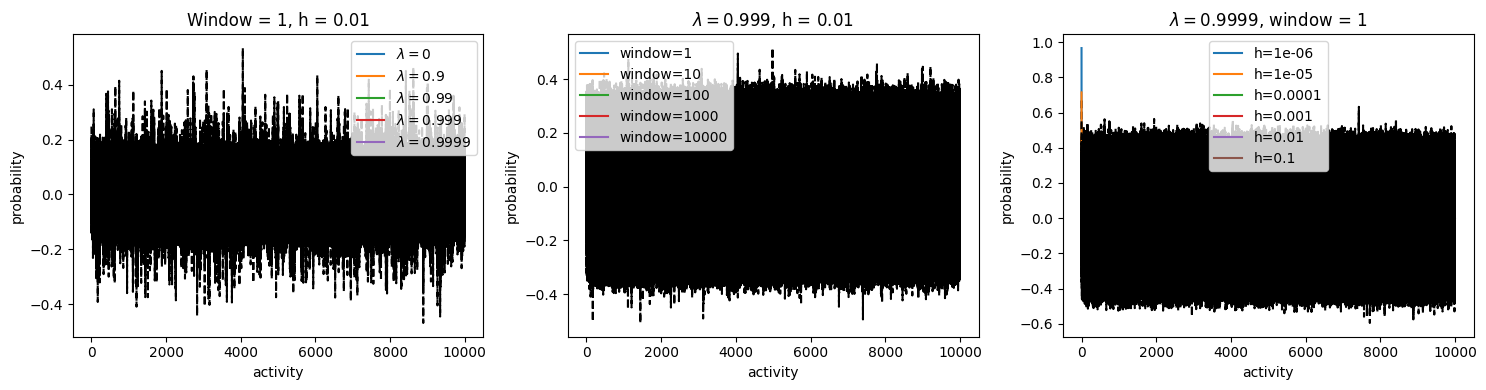

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# distributions for window 1, h=0.01 and lambdas [0 0.9 0.99, 0.999, 0.9999]
for i, lambda_ in enumerate([0, 0.9, 0.99, 0.999, 0.9999]):
    id = np.argwhere((Xs[:, 0]==1) & (Xs[:, 1]==lambda_) & (Xs[:,2]==0.01))[0][0]
    axes[0].plot(Ys[id], label=f"$\lambda={lambda_}$")
    # add model
    window, lambda_, h = Xs[id]
    x = np.array([np.log10(window), np.log10(1 - lambda_), np.log10(h)])
    y = model(torch.from_numpy(x).float()).detach().numpy()
    axes[0].plot(y, color='black', linestyle='--')

axes[0].set_title(f"Window = 1, h = 0.01")
axes[0].legend()
axes[0].set_xlabel("activity")
axes[0].set_ylabel("probability")
# axes[0].set_yscale('log')
# distributions for window [1,10,100,1000,10000], h=0.01 and lambdas [0.999]
for i, window in enumerate([1,10,100,1000,10000]):
    id = np.argwhere((Xs[:, 0]==window) & (Xs[:, 1]==0.999) & (Xs[:,2]==0.01))[0][0]
    axes[1].plot(Ys[id], label=f"window={window}")
    # add model
    window, lambda_, h = Xs[id]
    x = np.array([np.log10(window), np.log10(1 - lambda_), np.log10(h)])
    y = model(torch.from_numpy(x).float()).detach().numpy()
    axes[1].plot(y, color='black', linestyle='--')
axes[1].set_title(f"$\lambda=0.999$, h = 0.01")
axes[1].legend(loc='upper left')
axes[1].set_xlabel("activity")
axes[1].set_ylabel("probability")
# axes[1].set_yscale('log')
# distributions for window 1, h=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1] and lambdas [0.9999]
for i, h in enumerate([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]):
    id = np.argwhere((Xs[:, 0]==1) & (Xs[:, 1]==0.9999) & (Xs[:,2]==h))[0][0]
    axes[2].plot(Ys[id], label=f"h={h}")
    # add model
    window, lambda_, h = Xs[id]
    x = np.array([np.log10(window), np.log10(1 - lambda_), np.log10(h)])
    y = model(torch.from_numpy(x).float()).detach().numpy()
    axes[2].plot(y, color='black', linestyle='--')
axes[2].set_title(f"$\lambda=0.9999$, window = 1")  
axes[2].legend(loc='upper center')
axes[2].set_xlabel("activity")
axes[2].set_ylabel("probability")
# axes[2].set_yscale('log')
plt.tight_layout()

### Save function approximation to file

In [75]:
file_neural_network = f"./dat/neural_network_pmf_N={params['N']}_K={params['K']}_mu={params['mu']}_seed={params['seed']}.h5"

(4.5221233, 2196.5525)
(4.5221233, 2196.5525)
